In [1]:
import sys
import os
sys.path.append(os.path.abspath("../code"))

In [153]:
import voltage
import kmeans
import create_data
import time
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from typing import Callable, List, Optional, Union
import importlib

dist: List[float] = []

In [189]:
importlib.reload(create_data)
importlib.reload(kmeans)
importlib.reload(voltage)

<module 'voltage' from 'C:\\Users\\avigh\\Documents\\python\\VoltageDimentionalReduction\\code\\voltage.py'>

In [251]:
class BestParameterFinder2:
    def __init__(self):
        self.p_g: Optional[float] = None
        self.c: Optional[float] = None

    def setResistanceToGround(self, p_g: float) -> None:
        self.p_g = np.log(p_g)

    def setKernelWidth(self, c: float) -> None:
        self.c = np.log(c)

    def calculateVoltages(
        self,
        problem: voltage.Problem,
        landmark_idx: int,
        c: float,
        p_g: float,
        *,
        approx: bool = False,
        **approx_kwargs
    ) -> np.ndarray:
        problem.clearWeights()
        problem.setWeights(np.exp(c))
        problem.addUniversalGround(np.exp(p_g))
    
        solver = voltage.Solver(problem)
        if approx:
            return np.array(solver.approximate_voltages(**approx_kwargs))
        else:
            return np.array(solver.compute_voltages())

    def findBestParametersForEachLandmark(
        self,
        problem: voltage.Problem,
        landmark_indices: list[int],
        minBound: float = -25,
        maxBound: float = -1,
        granularity: int = 5,
        epsilon: float = 1,
        approx: bool = False,
        **approx_kwargs
    ) -> dict[int, tuple[float, float]]:
        results = {}
    
        for landmark_index in landmark_indices:
            bestc = (minBound + maxBound) / 2
            bestg = (minBound + maxBound) / 2
            window_size = (maxBound - minBound) / 2
            best_loss = float('inf')
    
            while window_size > epsilon:
                cs = [bestc + x * window_size / granularity for x in range(-granularity + 1, granularity)]
                gs = [bestg + x * window_size / granularity for x in range(-granularity + 1, granularity)]
    
                if self.c is not None:
                    cs = [self.c]
                if self.p_g is not None:
                    gs = [self.p_g]
    
                for c in cs:
                    for g in gs:
                        try:    
                            voltages = self.calculateVoltages(
                                problem, c, g, landmark_index,
                                approx=approx,
                                **approx_kwargs
                            )
    
                            mask = np.zeros_like(voltages, dtype=bool)
                            for tmp_idx in range(len(problem.landmarks)):
                                if (tmp_idx != landmark_index):
                                    mask[landmark_index] = True
                            loss = np.mean((voltages[mask] - 0.1) ** 2) / (np.std(voltages[mask]) + 1e-8)

                            # print(loss)
    
                            if loss < best_loss:
                                bestc, bestg = c, g
                                best_loss = loss
                        except ValueError:
                            pass

                window_size /= granularity
                print(bestc, bestg, window_size)
    
            results[landmark_index] = (np.exp(bestc), np.exp(bestg))

        problem.clearWeights()
        
        return results

In [252]:
data = create_data.Data("../inputoutput/data/line.json", stream=False)
n = len(data)

In [253]:
approximator = voltage.Problem(data)
approximator.addLandmark(voltage.Landmark.createLandmarkClosestTo(data, [3], 1))
approximator.addLandmark(voltage.Landmark.createLandmarkClosestTo(data, [0], 0))
approximator.setKernel(approximator.gaussiankernel)

In [254]:
bpf2 = BestParameterFinder2()
dictionary = bpf2.findBestParametersForEachLandmark(approximator, [0], 
                                                    approx=True,
                                                    max_iters=100,
                                                    minBound=-10, 
                                                    maxBound=10, 
                                                    granularity=5, 
                                                    epsilon=0.01)
print(dictionary)

-8.0 8.0 2.0
-9.6 9.6 0.4
-9.92 9.92 0.08
-9.984 9.984 0.016
-9.9968 9.9968 0.0032
{0: (4.55454422335078e-05, 21956.093759570515)}


In [259]:
grounded = voltage.Problem(data)
grounded.addLandmark(voltage.Landmark.createLandmarkClosestTo(data, [3], 1))

grounded.clearWeights()
grounded.setKernel(grounded.gaussiankernel)
grounded.setWeights(dictionary[0][0])
grounded.addUniversalGround(dictionary[0][1])

grounded_solver = voltage.Solver(grounded)
grounded_voltage = grounded_solver.approximate_voltages(max_iters=100)

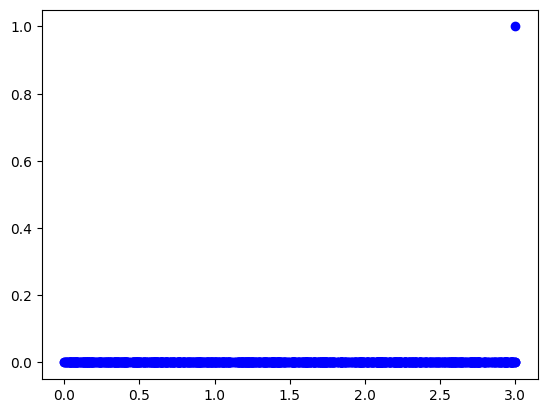

<Axes: >

In [258]:
plotter = create_data.Plotter()

plotter.voltage_plot(grounded_solver, color='b', label="Grounded Points")

In [239]:
print(grounded_voltage)

[0.09520764 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764
 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764
 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764
 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764
 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764
 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764
 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764
 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764
 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764
 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764
 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764
 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764
 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764
 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764
 0.09520764 0.09520764 0.09520764 0.09520764 0.09520764 0.0952

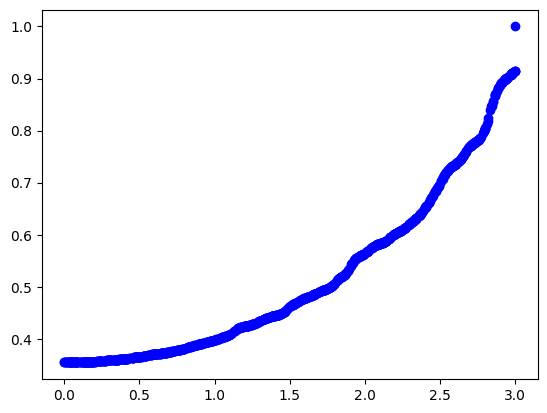

<Axes: >

In [184]:
manual_param = voltage.Problem(data)
manual_param.addLandmark(voltage.Landmark.createLandmarkClosestTo(data, [3], 1))

manual_param.setKernel(manual_param.gaussiankernel)
manual_param.setWeights(0.03)
manual_param.addUniversalGround(0.1)

manual_param_solver = voltage.Solver(manual_param)
# manual_param_voltage = manual_param_solver.approximate_voltages(max_iters=2000)
manual_param_voltage = manual_param_solver.compute_voltages()

plotter = create_data.Plotter()

plotter.voltage_plot(manual_param_solver, color='b', label="manual_param Points")

In [182]:
print(manual_param_voltage)

[0.02605627 0.30017943 0.02120441 0.43800571 0.0231828  0.6268696
 0.58246794 0.08790586 0.5603603  0.27931882 0.26566624 0.56507774
 0.37593283 0.36402066 0.10093349 0.0376096  0.21677379 0.01690952
 0.10250639 0.31600715 0.22190105 0.28029566 0.02957186 0.36511635
 0.03232859 0.18867529 0.02600363 0.38623369 0.58909529 0.0393866
 0.35031795 0.08968934 0.10516338 0.03260681 0.35586006 0.18091995
 0.05279234 0.4660092  0.64299831 0.03133394 0.37573642 0.39330013
 0.06390345 0.02563574 0.02075454 0.64703001 0.35186025 0.08607911
 0.11696541 0.59545064 0.31618105 0.27154578 0.09533158 0.0259744
 0.02191175 0.30354915 0.11094575 0.10658549 0.04746834 0.06874398
 0.34885174 0.25441438 0.18010689 0.1788304  0.03009073 0.03842727
 0.83416926 0.0909371  0.01682543 0.02116192 0.02124486 0.1065715
 0.01841755 0.0341461  0.01760398 0.85786936 0.1121883  0.0502029
 0.63494803 0.29039341 0.01686365 0.63375368 0.03245256 0.1546651
 0.03013611 0.84876174 0.28534985 0.08846328 0.37253125 0.11058188
 